running typecheck
Success: no issues found in 1 source file

running flake8
flake8 success
Inferred Frequency: 5.0 minutes


,o,h,l,c,v,vwap,date
count,5748,5748,5748,5748,5748,5748,5748
num_missing,0,0,0,1,0,0,0
pct_missing,0.0,0.0,0.0,0.000174,0.0,0.0,0.0
min,88.17,88.21,88.09,88.14,0.0,88.16,2018-01-01 09:00:00
max,102.09,102.11,1000.0,102.07,3832.0,102.07,2018-03-01 15:55:00


Errors:


,o,h,l,c,v,vwap,error
date,,,,,,,
2018-01-01 16:05:00,99.95,99.98,1000.0,99.96,631.0,99.96,bad low


Warnings:


,o,h,l,c,v,vwap,ret,warning
date,,,,,,,,
2018-01-01 16:00:00,99.79,99.84,99.75,99.77,863.0,99.795,NaN,l ret > 10 * std: 0.11963
2018-01-01 16:05:00,99.95,99.98,1000.00,99.96,631.0,99.960,9.025063,l ret > 10 * std: 0.11963


Time distribution:
**********************************************************************
File "__main__", line 387, in __main__.roll_futures
Failed example:
    assert np.maxx(df[df.series == 'MAR2018'].timestamp.values == np.datetime64('2018-03-14'))
Exception raised:
    Traceback (most recent call last):
      File "/Users/sal/mambaforge/envs/py39/lib/python3.9/doctest.py", line 1334, in __run
        exec(compile(example.source, filename, "single",
      File "<doctest __main__.roll_futures[5]>", line 1, in <module>
        assert np.maxx(df[df.series == 'MAR2018'].timestamp.values == np.datetime64('2018-03-14'))
      File "/Users/sal/mambaforge/envs/py39/lib/python3.9/site-packages/numpy/__init__.py", line 313, in __getattr__
        raise AttributeError("module {!r} has no attribute "
    AttributeError: module 'numpy' has no attribute 'maxx'
**********************************************************************
1 items had failures:
   1 of   7 in __main__.roll_futures
***Test

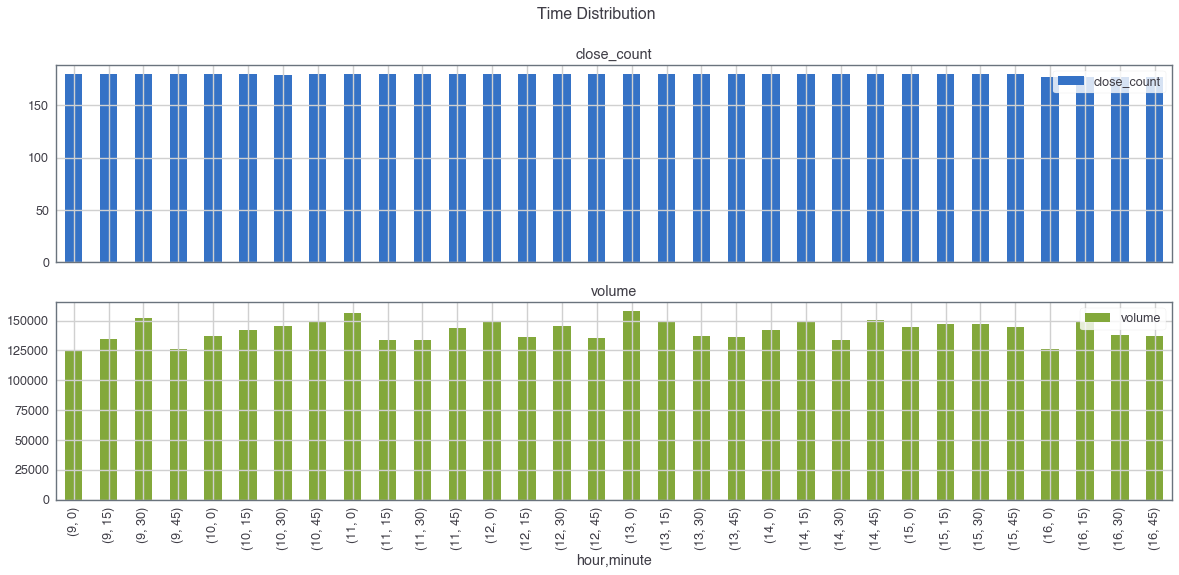

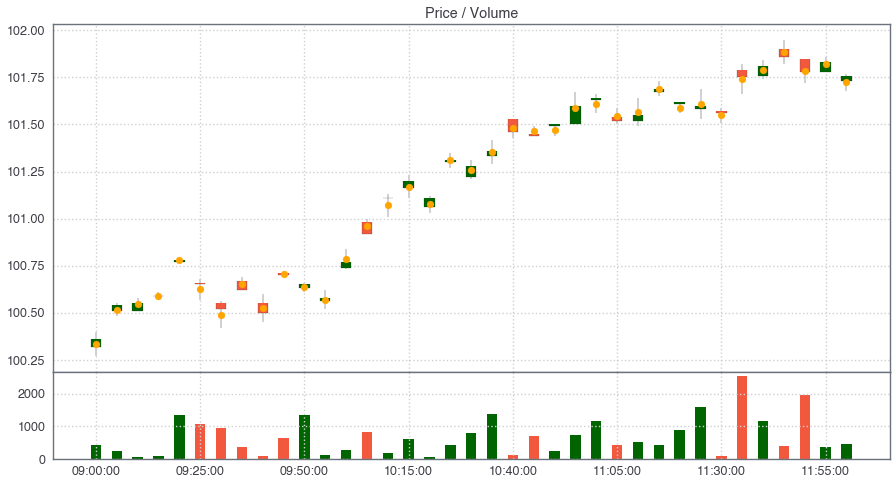

In [4]:
%%checkall
import pandas as pd
import numpy as np
import IPython.display as dsp
from pyqstrat.pq_utils import zero_to_nan, get_empty_np_value, infer_frequency, resample_trade_bars, has_display, strtup2date
from pyqstrat.plot import TradeBarSeries, TimeSeries, Subplot, Plot

from typing import Optional, Sequence, Tuple, Union, Callable


def _sort_trade_bars_key(a: str) -> int:
    sorted_cols = ['timestamp', 'o', 'h', 'l', 'c', 'v', 'vwap']
    if a in sorted_cols:
        return sorted_cols.index(a)
    else:
        return len(sorted_cols)
    

def sort_trade_bars(columns: Sequence[str]) -> Sequence[str]:
    '''Given a list of column names, sort them in olhcv order'''
    columns = sorted(list(columns))  # Use stable sort to sort columns that we don't know about alphabetically
    return sorted(columns, key=_sort_trade_bars_key)
    

class TradeBars:
    '''Used to store OHLCV bars.  You must at least supply timestamps and close prices.  All other fields are optional.
    
    Attributes:
        timestamp: A numpy datetime array with the datetime for each bar.  Must be monotonically increasing.
        c:     A numpy float array with close prices for the bar.
        o:     A numpy float array with open prices . Default None
        h:     A numpy float array with high prices. Default None
        l:     A numpy float array with high prices. Default None
        v:     A numpy integer array with volume for the bar. Default None
        vwap:  A numpy float array with the volume weighted average price for the bar.  Default None
    '''
    def __init__(self, 
                 timestamps: np.ndarray, 
                 c: np.ndarray, 
                 o: Optional[np.ndarray] = None, 
                 h: Optional[np.ndarray] = None, 
                 l: Optional[np.ndarray] = None,  # noqa: E741: ignore # l ambiguous
                 v: Optional[np.ndarray] = None, 
                 vwap: Optional[np.ndarray] = None) -> None:
        '''Zeroes in o, h, l, c are set to nan'''
        assert(len(timestamps) > 1)
        assert(len(c) == len(timestamps))
        assert(o is None or len(o) == len(timestamps))
        assert(h is None or len(h) == len(timestamps))
        assert(l is None or len(l) == len(timestamps))
        assert(v is None or len(v) == len(timestamps))
        assert(vwap is None or len(vwap) == len(timestamps))
        
        if not np.all(np.diff(timestamps).astype(float) > 0):  # check for monotonically increasing timestamps
            raise Exception('timestamps must be unique monotonically increasing')
        self.timestamps, self.o, self.h, self.l, self.c, self.v, self.vwap = timestamps, o, h, l, c, v, vwap
            
        for field in ['timestamps', 'h', 'l', 'c', 'v', 'vwap']:
            v = getattr(self, field)
            if isinstance(v, pd.Series):
                setattr(self, field, v.values)
                
        for field in ['o', 'h', 'l', 'c']:
            setattr(self, field, zero_to_nan(getattr(self, field)))
        
        self._set_valid_rows()
        
    def add_timestamps(self, timestamps: np.ndarray) -> None:
        '''
        Adds new timestamps to a market data object.
        
        Args:
            timestamps (np.array of np.datetime64): New timestamps to add.  Does not have to be sorted or unique
        
        >>> timestamps = np.array(['2018-01-05', '2018-01-09', '2018-01-10'], dtype = 'M8[ns]')
        >>> c = np.array([8.1, 8.2, 8.3])
        >>> o = np.array([9, 10, 11])
        >>> trade_bar = TradeBars(timestamps, c, o)
        >>> new_timestamps = np.array(['2018-01-07', '2018-01-09'], dtype = 'M8[ns]')
        >>> trade_bar.add_timestamps(new_timestamps)
        >>> print(trade_bar.timestamps)
        ['2018-01-05T00:00:00.000000000' '2018-01-07T00:00:00.000000000'
         '2018-01-09T00:00:00.000000000' '2018-01-10T00:00:00.000000000']
        >>> np.set_printoptions(formatter = {'float': lambda x: f'{x:.4f}'})  # After numpy 1.13 positive floats don't have a leading space for sign
        >>> print(trade_bar.o, trade_bar.c)
        [9.0000 nan 10.0000 11.0000] [8.1000 nan 8.2000 8.3000]
        '''
        if timestamps is None or len(timestamps) == 0: return
        timestamps = np.unique(timestamps)
        new_timestamps = np.setdiff1d(timestamps, self.timestamps, assume_unique=True)
        all_timestamps = np.concatenate([self.timestamps, new_timestamps])
        col_list = ['o', 'h', 'l', 'c', 'vwap']
        sort_index = all_timestamps.argsort()
        for col in col_list:
            v = getattr(self, col)
            if v is None: continue
            dtype = getattr(self, col).dtype
            fill_value = get_empty_np_value(dtype)
            v = np.concatenate([v, np.full(len(new_timestamps), fill_value, dtype=dtype)])
            v = v[sort_index]
            setattr(self, col, v)
        self.timestamps = np.sort(all_timestamps)
        self._set_valid_rows
        
    def _get_fill_value(self, col_name: str) -> np.generic:
        dtype = getattr(self, col_name).dtype
        return get_empty_np_value(dtype)
        
    def _set_valid_rows(self) -> None:
        col_list = [col for col in [self.o, self.h, self.l, self.c, self.vwap] if col is not None]
        nans = np.any(np.isnan(col_list), axis=0)  # type: ignore
        self.valid_rows = ~nans
    
    def valid_row(self, i: int) -> bool:
        '''Return True if the row with index i has no nans in it.'''
        return self.valid_rows[i]
    
    def resample(self, sampling_frequency: str) -> Optional['TradeBars']:
        '''
        Downsample the trade bars data into a new bar frequency
        
        Args:
            sampling_frequency: See sampling frequency in pandas
        '''
        if sampling_frequency is None:
            return self
        
        df = self.df()
        # Rename timestamps to timestamp
        df.index.name = 'timestamp'

        df = resample_trade_bars(df, sampling_frequency)
        o = df.o if 'o' in df.columns else None
        h = df.h if 'h' in df.columns else None
        _l = df.l if 'l' in df.columns else None
        v = df.v if 'v' in df.columns else None
        vwap = df.vwap if 'vwap' in df.columns else None
              
        trade_bar = TradeBars(df.timestamp, df.c, o, h, _l, v, vwap)
            
        trade_bar._set_valid_rows()
        
        return trade_bar
    
    def errors(self, display: bool = True) -> Optional[pd.DataFrame]:
        '''Returns a dataframe indicating any highs that are lower than opens, closes, lows or lows that are higher than other columns
        Also includes any ohlcv values that are negative
        '''
        df = self.df()
        errors_list = []
        if 'h' in df.columns:
            bad_highs = df[(df.h < df.c) | (df.h < df.o)]
            if len(bad_highs):                 
                bad_highs.insert(len(df.columns), 'error', 'bad high')
                errors_list.append(bad_highs)
        if 'l' in df.columns:
            bad_lows = df[(df.l > df.c) | (df.l > df.o)]
            if len(bad_lows): 
                bad_lows.insert(len(df.columns), 'error', 'bad low')
                errors_list.append(bad_lows)

        neg_values_mask = (df.c < 0)
        for col in ['o', 'h', 'l', 'c', 'v', 'vwap']:
            if col in df.columns:
                neg_values_mask |= (df[col] < 0)
        neg_values = df[neg_values_mask]
        if len(neg_values): 
            neg_values.insert(len(df.columns), 'error', 'negative values')
            errors_list.append(neg_values)
            
        if not len(errors_list): return None
            
        df = pd.concat(errors_list)
        df = df[sort_trade_bars(df.columns)]
        
        if display: dsp.display(df)
        return df
    
    def warnings(self, warn_std: int = 10, display: bool = True) -> pd.DataFrame:
        '''Returns a dataframe indicating any values where the bar over bar change is more than warn_std standard deviations.
        
        Args:
            warn_std: Number of standard deviations to use as a threshold (default 10)
            display:  Whether to print out the warning dataframe as well as returning it
        '''
        df = self.df()
        warnings_list = []

        for col in ['o', 'h', 'l', 'c', 'vwap']:
            if col in df.columns:
                ret = np.abs(df[col].pct_change())
                std = ret.std()
                mask = ret > warn_std * std
                df_tmp = df[mask]
                if len(df_tmp):
                    double_mask = mask | mask.shift(-1)  # Add the previous row so we know the two values computing a return
                    df_tmp = df[double_mask]
                    df_tmp.insert(len(df_tmp.columns), 'ret', ret[mask])
                    df_tmp.insert(len(df_tmp.columns), 'warning', f'{col} ret > {warn_std} * std: {std:.5g}')
                    warnings_list.append(df_tmp)

        if not len(warnings_list): return None
        df = pd.concat(warnings_list)
        df = df[sort_trade_bars(df.columns)]
        if display: dsp.display(df)
        return df
                              
    def overview(self, display: bool = True) -> pd.DataFrame:
        '''Returns a dataframe showing basic information about the data, including count, number and percent missing, min, max
        
        Args:
            display:  Whether to print out the warning dataframe as well as returning it
        '''
        df = self.df().reset_index()
        df_overview = pd.DataFrame({'count': len(df), 
                                    'num_missing': df.isnull().sum(), 
                                    'pct_missing': df.isnull().sum() / len(df), 
                                    'min': df.min(), 
                                    'max': df.max()})
        df_overview = df_overview.T
        df_overview = df_overview[sort_trade_bars(df_overview.columns)]
        if display: dsp.display(df_overview)
        return df_overview
       
    def time_distribution(self, 
                          frequency: str = '15 minutes', 
                          display: bool = True, 
                          plot: bool = True, 
                          figsize: Optional[Tuple[int, int]] = None) -> pd.DataFrame:
        '''
        Return a dataframe with the time distribution of the bars
        
        Args:
            frequency: The width of each bin (default "15 minutes").  You can use hours or days as well.
            display:   Whether to display the data in addition to returning it.
            plot:      Whether to plot the data in addition to returning it.
            figsize:   If plot is set, optional figure size for the plot (default (20,8))
        '''
        group_col = None
        
        n = int(frequency.split(' ')[0])
        freq = frequency.split(' ')[1]
        
        df = self.df().reset_index()
        
        if freq == 'minutes' or freq == 'mins' or freq == 'min':
            group_col = [df.date.dt.hour, df.date.dt.minute // n * n]
            names = ['hour', 'minute']
        elif freq == 'hours' or freq == 'hrs' or freq == 'hr':
            group_col = [df.date.dt.weekday_name, df.date.dt.hour // n * n]
            names = ['weekday', 'hour']
        elif freq == 'weekdays' or freq == 'days' or freq == 'day':
            group_col = df.date.dt.weekday_name // n * n
            names = ['weekday']
        else:
            raise Exception(f'unknown time freq: {freq}')
            
        count = df.groupby(group_col)['c'].count()
        tdf = pd.DataFrame({'close_count': count, 'count_pct': count / df.c.count()})[['close_count', 'count_pct']]
            
        if 'v' in df.columns:
            vsum = df.groupby(group_col)['v'].sum()
            vdf = pd.DataFrame({'volume': vsum, 'volume_pct': vsum / df.v.sum()})[['volume', 'volume_pct']]
            tdf = pd.concat([vdf, tdf], axis=1)
            
        tdf.index.names = names
            
        if display:
            dsp.display(tdf)
    
        if plot:
            if not figsize: figsize = (20, 8)
            cols = ['close_count', 'volume'] if 'v' in df.columns else ['close_count']
            if not has_display():
                print('no display found, cannot plot time distribution')
                return tdf
            tdf[cols].plot(figsize=figsize, kind='bar', subplots=True, title='Time Distribution')
            
        return tdf
    
    def freq_str(self) -> str:
        
        freq = infer_frequency(self.timestamps)
        if freq < 1:
            freq_str = f'{round(freq * 24. * 60, 2)} minutes'
        else:
            freq_str = f'{freq} days'
        return freq_str
            
    def describe(self, 
                 warn_std: int = 10, 
                 time_distribution_frequency: str = '15 min', 
                 print_time_distribution: bool = False) -> None:
        '''
        Describe the bars.  Shows an overview, errors and warnings for the bar data.  This is a good function to use 
        before running any backtests on a set of bar data.
        
        Args:
            warn_std: See warning function
            time_distribution_frequency: See time_distribution function
            print_time_distribution: Whether to print the time distribution in addition to plotting it.
        '''
        print(f'Inferred Frequency: {self.freq_str()}')
        self.overview()
        print('Errors:')
        self.errors()
        print('Warnings:')
        self.warnings(warn_std=warn_std)
        print('Time distribution:')
        self.time_distribution(display=print_time_distribution, frequency=time_distribution_frequency)
        
    def has_ohlc(self) -> bool:
        '''
        Returns True if we have all ohlc columns and none are empty
        '''
        return not (self.o is None or self.h is None or self.l is None or self.c is None)

    def plot(self,
             figsize: Tuple[int, int] = (15, 8),
             date_range: Optional[Union[Tuple[str, str], Tuple[Optional[np.datetime64], Optional[np.datetime64]]]] = None,
             sampling_frequency: str = None,
             title: str = 'Price / Volume') -> None:
        '''
        Plot a candlestick or line plot depending on whether we have ohlc data or just close prices
        
        Args:
            figsize: Size of the figure (default (15,8))
            date_range: A tuple of strings or numpy datetimes for plotting a smaller sample of the data, e.g. ("2018-01-01", "2018-01-06")
            sampling_frequency: Downsample before plotting.  See pandas frequency strings for possible values.
            title: Title of the graph, default "Price / Volume"
        '''
        if date_range and isinstance(date_range[0], str):
            date_range = strtup2date(date_range)
        data: Union[TradeBarSeries, TimeSeries]
        if self.has_ohlc():
            data = TradeBarSeries('price', self.timestamps, self.o, self.h, self.l, self.c, self.v, self.vwap)
        else:
            data = TimeSeries('price', self.timestamps, self.c)
        subplot = Subplot(data)
        plot = Plot([subplot], figsize=figsize, date_range=date_range, sampling_frequency=sampling_frequency, title=title)
        plot.draw()
                              
    def df(self, 
           start_date: Optional[np.datetime64] = None, 
           end_date: Optional[np.datetime64] = None) -> pd.DataFrame:
        df = pd.DataFrame({'date': self.timestamps, 'c': self.c}).set_index('date')
        for tup in [('o', self.o), ('h', self.h), ('l', self.l), ('v', self.v), ('vwap', self.vwap)]:
            if tup[1] is not None: df.insert(0, tup[0], tup[1])
        if start_date: df = df[df.index.values >= start_date]
        if end_date: df = df[df.index.values <= end_date]
        return df
    
    
def roll_futures(fut_prices: pd.DataFrame, 
                 date_func: Callable[[pd.DataFrame], np.ndarray], 
                 condition_func: Callable[[pd.DataFrame], np.ndarray], 
                 expiries: pd.DataFrame = None,
                 return_full_df: bool = False) -> pd.DataFrame:
    '''Construct a continuous futures dataframe with one row per datetime given rolling logic
    
    Args:
        fut_prices: A dataframe containing the columns 'date', 'series', and any other market data, 
            for example, ohlcv data. Date can contain time for sub-daily bars. 
            The series column must contain a different string name for each futures series, e.g. SEP2018, DEC2018, etc.
        date_func: A function that takes the future prices as an input and returns a numpy array of booleans
          True indicates that the future should be rolled on this date if the condition specified in condition_func is met.
          This function can assume that we have all the columns in the original market data object plus the same 
          columns suffixed with _next for the potential series to roll over to.
        condition_func: A function that takes the future prices as input and returns a numpy array of booleans.
          True indicates that we should try to roll the future at that row.
        expiries: An optional dataframe with 2 columns, 'series' and 'expiry'.  This should have one row per future series 
            indicating that future's expiry date.
            If you don't pass this in, the function will assume that the expiry column is present in the original dataframe.
        return_full_df: If set, will return the datframe without removing extra timestamps so you can use your own logic for rolling, 
            including the _next columns and the roll flag
          
    Returns:
        A pandas DataFrame with one row per date, which contains the columns in the original md DataFrame and the same columns suffixed with _next 
          representing the series we want to roll to.  There is also a column called roll_flag which is set to True whenever 
          the date and roll condition functions are met.

          
    >>> fut_prices = pd.DataFrame({'timestamp': np.concatenate((np.arange(np.datetime64('2018-03-11'), np.datetime64('2018-03-16')),
    ...                                           np.arange(np.datetime64('2018-03-11'), np.datetime64('2018-03-16')))),
    ...                   'c': [10, 10.1, 10.2, 10.3, 10.4] + [10.35, 10.45, 10.55, 10.65, 10.75],
    ...                   'v': [200, 200, 150, 100, 100] + [100, 50, 200, 250, 300],
    ...                   'series': ['MAR2018'] * 5 + ['JUN2018'] * 5})[['timestamp','series', 'c', 'v']]
    >>> expiries = pd.Series(np.array(['2018-03-15', '2018-06-15'], dtype = 'M8[D]'), index = ['MAR2018', 'JUN2018'], name = "expiry")
    >>> date_func = lambda fut_prices: fut_prices.expiry - fut_prices.timestamp <= np.timedelta64(3, 'D')
    >>> condition_func = lambda fut_prices: fut_prices.v_next > fut_prices.v
    >>> df = roll_futures(fut_prices, date_func, condition_func, expiries)
    >>> assert np.max(df[df.series == 'MAR2018'].timestamp.values == np.datetime64('2018-03-14'))
    >>> assert(np.max(df[df.series == 'JUN2018'].timestamp.values) == np.datetime64('2018-03-15'))
    '''
    if 'timestamp' not in fut_prices.columns or 'series' not in fut_prices.columns:
        raise Exception('timestamp or series not found in columns: {fut_prices.columns}')
        
    if expiries is not None:
        expiries = expiries.to_frame(name='expiry')
        fut_prices = pd.merge(fut_prices, expiries, left_on=['series'], right_index=True, how='left')
    else:
        if 'expiry' not in fut_prices.columns: raise Exception('expiry column must be present in market data if expiries argument is not specified')
        expiries = fut_prices[['series', 'expiry']].drop_duplicates().sort_values(by='expiry').set_index('s')

    expiries = pd.merge(expiries, expiries.shift(-1), left_index=True, right_index=True, how='left', suffixes=['', '_next'])

    orig_cols = [col for col in fut_prices.columns if col not in ['timestamp']]
    fut_prices1 = pd.merge(fut_prices, expiries[['expiry', 'expiry_next']], on=['expiry'], how='left')
    fut_prices = pd.merge(fut_prices1, fut_prices, left_on=['timestamp', 'expiry_next'],
                          right_on=['timestamp', 'expiry'], how='left', suffixes=['', '_next'])

    fut_prices = fut_prices.sort_values(by=['expiry', 'timestamp'])

    roll_flag = date_func(fut_prices) & condition_func(fut_prices) 

    df_roll = pd.DataFrame({'series': fut_prices.series, 'timestamp': fut_prices.timestamp, 'roll_flag': roll_flag})
    df_roll = df_roll[df_roll.roll_flag].groupby('series', as_index=False).first()
    fut_prices = pd.merge(fut_prices, df_roll, on=['series', 'timestamp'], how='left')
    fut_prices.roll_flag = fut_prices.roll_flag.fillna(False)
    
    cols = ['timestamp'] + orig_cols + [col + '_next' for col in orig_cols] + ['roll_flag']
    fut_prices = fut_prices[cols]
    
    if return_full_df: return fut_prices
    
    df_list = []
    for series, g in fut_prices.groupby('expiry'):
        roll_flag = g.roll_flag
        true_values = roll_flag[roll_flag]
        if len(true_values):
            first_true_index = true_values.index[0]
            roll_flag = roll_flag[first_true_index:]
            false_after_true_values = roll_flag[~roll_flag]
            if len(false_after_true_values):
                first_false_after_true_idx = false_after_true_values.index[0]
                g = g.loc[:first_false_after_true_idx]
        df_list.append(g)

    full_df = pd.concat(df_list)
    full_df = full_df.sort_values(by=['expiry', 'timestamp']).drop_duplicates(subset=['timestamp'])

    return full_df


def test_trade_bars() -> None:
    from datetime import datetime, timedelta
    np.random.seed(0)
    timestamps: np.ndarray = np.arange(datetime(2018, 1, 1, 9, 0, 0), 
                                       datetime(2018, 3, 1, 16, 0, 0), timedelta(minutes=5))
    timestamps = np.array([dt for dt in timestamps.astype(object) if dt.hour >= 9 and dt.hour <= 16]).astype('M8[m]')
    rets = np.random.normal(size=len(timestamps)) / 1000
    c_0 = 100
    c = np.round(c_0 * np.cumprod(1 + rets), 2)
    _l = np.round(c * (1. - np.abs(np.random.random(size=len(timestamps)) / 1000.)), 2)  # PEP8 thinks l is hard to distinguish
    h = np.round(c * (1. + np.abs(np.random.random(size=len(timestamps)) / 1000.)), 2)
    o = np.round(_l + (h - _l) * np.random.random(size=len(timestamps)), 2)
    v = np.abs(np.round(np.random.normal(size=len(timestamps)) * 1000))
    vwap = 0.5 * (_l + h)
    c[18] = np.nan
    _l[85] = 1000
    trade_bar = TradeBars(timestamps, c, o, h, _l, v, vwap)
    trade_bar.describe()
    trade_bar.plot(date_range=('2018-01-02', '2018-01-02 12:00'))


if __name__ == "__main__":
    test_trade_bars()
    import doctest
    doctest.testmod(optionflags=doctest.NORMALIZE_WHITESPACE)